# electricityMap Data Science challenge
> Guillaume Picard, Dec 2020

#### Challenge
We are interested in historical electricity production data on an hourly basis for **South Korea**.

The goal is to create a model for **hourly historical electricity production estimates broken down by fuel source from Jan 1st - Dec 31st, 2019**.

Additionally, the sythesized dataset would use the following output format:

| Column name | Unit |
|---|---|
datetime | ISO format (UTC)
timestamp | Integer
zone_name | string
total_consumption_avg | MW
power_production_biomass_avg | MW
power_production_coal_avg | MW
power_production_gas_avg | MW
power_production_hydro_avg | MW
power_production_nuclear_avg | MW
power_production_oil_avg | MW
power_production_solar_avg | MW
power_production_wind_avg | MW
power_production_geothermal_avg | MW
power_production_unknown_avg | MW

**Finding reliable data**

The first challenge was to find reliable data sources for electricity production in South Korea broken down by fuel source in 2019. We also needed electricity consumption to fit the above expected format of the csv.

I came across two high-quality datasources that gave me this information at an annual, monthly, and daily level of granularity:
- **[Korea Energy Statistical Information System (KESIS)](http://www.kesis.net/main/main.jsp)**: they use data from Korea Electric Power Corporation (KEPC)
- **[Electric Power Statistics Information Systems (EPSIS)](http://epsis.kpx.or.kr/epsisnew/selectMain.do)**:  they use a mix of data from Korean Electric Power Statistics (provided by KEPCO) and the Electric Power Market Operation Statistics (provided by KPX)

**Lack of hourly historical data**

Early on in the challenge it was clear that despite the availability of some real-time data, there was a lack of historical production and/or consumption data broken down by hourly segments. 

One example of limited, real-time supply data was from [EPSIS](http://epsis.kpx.or.kr/epsisnew/selectEkgeEpsMepRealChart.do?menuId=030300):

![Data from Nov. 31st, 2020 (grey) and Dec 1st, 2020 (blue)](data/formatted_data/sample_daily_production_image.png)
<center><b>Data from Nov. 31st, 2020 (grey) and Dec 1st, 2020 (blue)</b></center>
<br>
The above dataset at least gives a sense of how supply loads change throughout the day at an hourly level in South Korea. I will assume from here that this is roughly what the supply curve looks, and will build a model based on this assumption as well as make some slight adjustments for seasonality and other possible factors.

---

_Notes on data_

The `data/formatted_data` folder contains 4 .csv and 1 excel file each derived from the above two sources, KESIS and EPSIS. The original data files are also included in `data/raw_data`. Below is a list of the filename and where the data came from:

`monthly_electricity_generation_2019.csv` \
_Based on data from KESIS. Electricity generation data broken down  by power source_ \
Source: [http://www.kesis.net/sub/subChartEng.jsp?report_id=33111&reportType=0](http://www.kesis.net/sub/subChartEng.jsp?report_id=33111&reportType=0)

`capacity_by_energy_source_2019.csv`
_Based on data from EPSIS. Generation capacity broken down by energy source._ \
Source: [http://epsis.kpx.or.kr/epsisnew/selectEkfaFclFesGrid.do?menuId=020702&locale=eng](http://epsis.kpx.or.kr/epsisnew/selectEkfaFclFesGrid.do?menuId=020702&locale=eng)

`generation_by_energy_source_2019.csv`\
_Based on data from EPSIS. Generation output broken down by energy source. Non-utility self-generation was excluded to simplify modeling as it only represents 0.2% of yearly total generation._ \
Source: [http://epsis.kpx.or.kr/epsisnew/selectEkgeGepGesGrid.do?menuId=060102&locale=eng](http://epsis.kpx.or.kr/epsisnew/selectEkgeGepGesGrid.do?menuId=060102&locale=eng)

`electric_power_supply_and_demand_2019.csv` \
_Based on data from EPSIS. Electric Power Daily Peak Demand._ \
Source: [http://epsis.kpx.or.kr/epsisnew/selectEkgeEpsMepChart.do?menuId=030100&locale=eng](http://epsis.kpx.or.kr/epsisnew/selectEkgeEpsMepChart.do?menuId=030100&locale=eng)

`generation_attribution_by_fuel_source_2019.xlsx` \
_Based on data from EPSIS. Generation output broken down by energy source. Data is split out to attribute the various energy sources based on the main power source classification_ \
Source: [http://epsis.kpx.or.kr/epsisnew/selectEkgeGepGesGrid.do?menuId=060102&locale=eng](http://epsis.kpx.or.kr/epsisnew/selectEkgeGepGesGrid.do?menuId=060102&locale=eng)

---

In [1]:
import re
from datetime import datetime
from datetime import timedelta
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
monthly_generation = pd.read_csv("data/formatted_data/monthly_electricity_generation_2019.csv")
capacity = pd.read_csv("data/formatted_data/capacity_by_energy_source_2019.csv")
generation = pd.read_csv("data/formatted_data/generation_by_energy_source_2019.csv")
peak_demand = pd.read_csv("data/formatted_data/electric_power_supply_and_demand_2019.csv")

# dict to convert energy source name to fuel source output format
key_energy_source = {
    'Pumped-Storage':'hydro', 
    'Anthracite coal':'coal', 
    'Bituminous coal':'coal', 
    'Oil':'oil',
    'LNG':'gas', 
    'Nuclear':'nuclear', 
    'Others':'unknown', 
    'Hydro Power':'hydro', 
    'Solar Power':'solar',
    'Wind Power':'wind', 
    'Marine Energy':'unknown', 
    'Bio Energy':'biomass', 
    'Waste Energy':'unknown',
    'Landfill Gas':'gas', 
    'Off-Gas':'gas', 
    'Fuel Cell':'unknown', 
    'IGCC': 'coal',
    'Group Energy(Renewables)':'unknown'
}

# dict to attribute fuel source to each power source 
# based on analysis in generation_attribution_by_fuel_source_2019.xlsx
key_power_source = {
    'Hydro(MWh)': [("hydro", 0.5536), ("hydro",0.4464)], 
    'Steam(MWh)': [("coal", 0.0110),("coal", 0.9704),("oil", 0.0081),("gas", 0.0003),("biomass", 0.0079),("unknown", 0.0022)], 
    'Combined cycle(MWh)': [("oil", 0.0058),("gas", 0.9942)],
    'Internal combustion(MWh)': [("oil", 1.0)], 
    'Nuclear(MWh)': [("nuclear", 1.0)], 
    'Renewables(MWh)': [("solar", 0.3866),("wind", 0.0874),("unknown", 0.0155),("biomass", 0.1586),("unknown", 0.0261),("gas", 0.0077),("unknown", 0.2104), ("unknown", 0.0739), ("coal", 0.0338)],
    'Others(MWh)': [("unknown", 1.0)]
}

monthly_generation["Day"] = 1
monthly_generation["datetime"] =  pd.to_datetime(monthly_generation[["Year","Month","Day"]])
monthly_generation = monthly_generation[['Year', 'Month', 'Day', 'datetime',
                                         'Total(MWh)', 'Hydro(MWh)', 'Steam(MWh)',
                                         'Combined cycle(MWh)', 'Internal combustion(MWh)', 'Nuclear(MWh)',
                                         'Renewables(MWh)', 'Others(MWh)']]
sum_df = pd.DataFrame()
for c in monthly_generation.columns[5:]:
    for fuel_source, p in key_power_source[c]:
        if fuel_source not in sum_df.columns:
            sum_df[fuel_source] = monthly_generation[c]*p
        else:
            sum_df[fuel_source] += monthly_generation[c]*p
            
monthly_generation = pd.concat((monthly_generation, sum_df.round()), axis=1)
monthly_generation = monthly_generation[['Year', 'Month', 'Day', 'datetime', 'Total(MWh)','biomass','coal','gas','hydro','nuclear','oil','solar','wind','unknown']]
#####

peak_demand.sort_values(["Year","Month","Day"], inplace=True)
peak_demand["datetime"] = pd.to_datetime(peak_demand[['Year', 'Month', 'Day']])
peak_demand["Peak\rDemand Date"] = peak_demand["Peak\rDemand Date"].apply(lambda x:re.sub("24:00", "00:00", x))
peak_demand["Peak\rDemand Date"] = pd.to_datetime(peak_demand["Peak\rDemand Date"], format="%Y/%m/%d(%H:%M)")
peak_demand["Peak Demand Hour"] = peak_demand["Peak\rDemand Date"].dt.hour
peak_demand["Peak Demand Day"] = peak_demand.datetime.dt.weekday

# convert original energy source classifications into the output format
capacity["Classification"] = capacity["Classification"].apply(lambda x:key_energy_source[x])
generation["Classification"] = generation["Classification"].apply(lambda x:key_energy_source[x])


#### Understanding capacity by fuel source in 2019

The breakdown in capacity will help us understand how much maximum energy is available from each source

In [3]:
capacity.groupby("Classification").sum()

,Total Capacity (MWh)
Classification,
biomass,833.5
coal,37349.7
gas,39616.5
hydro,6508.1
nuclear,23250.0
oil,3864.4
solar,10505.1
unknown,1898.0
wind,1512.2


In [4]:
capacity.groupby("Classification").sum()/capacity["Total Capacity (MWh)"].sum()

,Total Capacity (MWh)
Classification,
biomass,0.006650
coal,0.297993
gas,0.316079
hydro,0.051925
nuclear,0.185499
oil,0.030832
solar,0.083815
unknown,0.015143
wind,0.012065


#### Understanding generation by fuel source in 2019

The breakdown in generation will help us understand how much energy was generated by each source in 2019

In [5]:
generation.groupby("Classification").sum()

,Total Generation (GWh)
Classification,
biomass,6679.18
coal,228415.35
gas,150784.95
hydro,6247.06
nuclear,145909.67
oil,3292.25
solar,11800.97
unknown,6095.00
wind,2669.47


In [6]:
generation.groupby("Classification").sum()/generation["Total Generation (GWh)"].sum()

,Total Generation (GWh)
Classification,
biomass,0.011887
coal,0.406510
gas,0.268351
hydro,0.011118
nuclear,0.259675
oil,0.005859
solar,0.021002
unknown,0.010847
wind,0.004751


#### Understanding generation monthly trend by power source

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


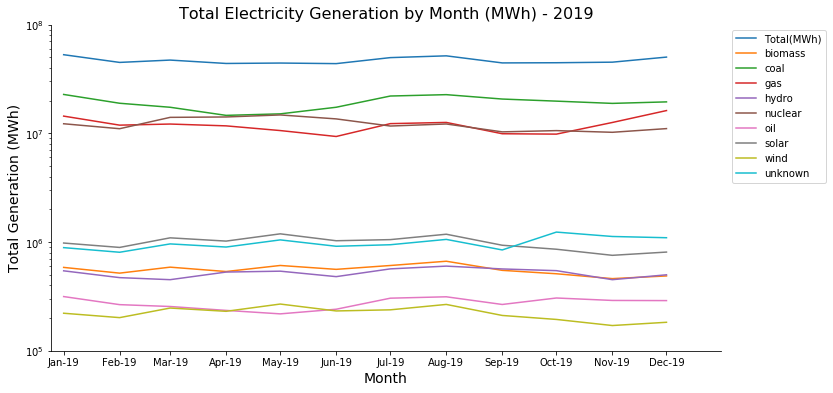

In [7]:
fig, ax = plt.subplots(figsize=(12,6))

for c in monthly_generation.columns[4:]:
    ax.plot(monthly_generation["datetime"].values, monthly_generation[c].values, label=c)

fmt = mdates.DateFormatter('%b-%y')
ax.xaxis.set_major_formatter(fmt)
locator = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(locator)

ax.set_xlim([datetime(2018, 12, 25), datetime(2019, 12, 31)])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_ylabel("Total Generation (MWh)", fontsize=14)
ax.set_xlabel("Month", fontsize=14)

ax.set_title("Total Electricity Generation by Month (MWh) - 2019", fontsize=16)

ax.legend(bbox_to_anchor=(1.01, 1.0))

plt.yscale("log")
plt.ylim(100000,100000000)

plt.show()

#### Understanding peak demand daily trend

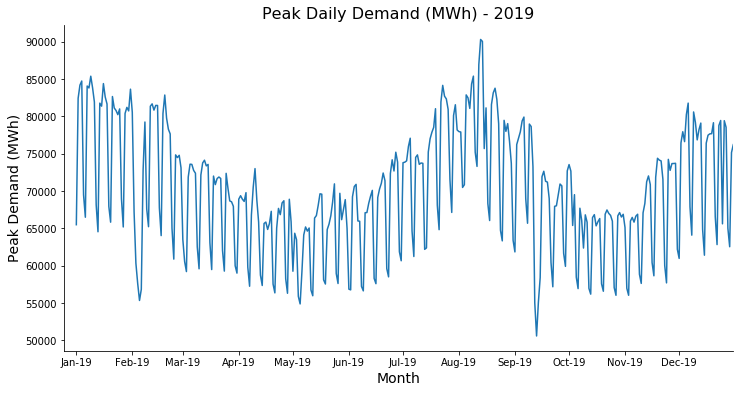

In [8]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(peak_demand["datetime"].values, peak_demand["Peak\rDemand (MW)"].values)

fmt = mdates.DateFormatter('%b-%y')
ax.xaxis.set_major_formatter(fmt)
locator = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(locator)

ax.set_xlim([datetime(2018, 12, 25), datetime(2019, 12, 31)])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_ylabel("Peak Demand (MWh)", fontsize=14)
ax.set_xlabel("Month", fontsize=14)

ax.set_title("Peak Daily Demand (MWh) - 2019", fontsize=16)

plt.show()

Interesting aspects of the above visualization - peaks occur during weekdays and troughs occur during weekends and holidays. The large troughs in February and September correlate with the widely popular Korea holidays of Lunar New Year and Chuseok.

--- 
### Building the model

Using these building blocks, I can create a model that splits up the daily generation data into an hourly trend broken down by fuel source.

Here are elements of the modeling approach:

1. **Capacity and Generation data are a gut-check** to make sure the numbers make sense
2. **Peak daily demand is used to calibrate the hourly production curve daily peak production**
3. **Monthly generation data is used to split out and attribute production to different fuel sources**
4. **The EPSIS real-time supply curve is used as a reference for hourly production on a daily basis**

#### Understanding peak demand

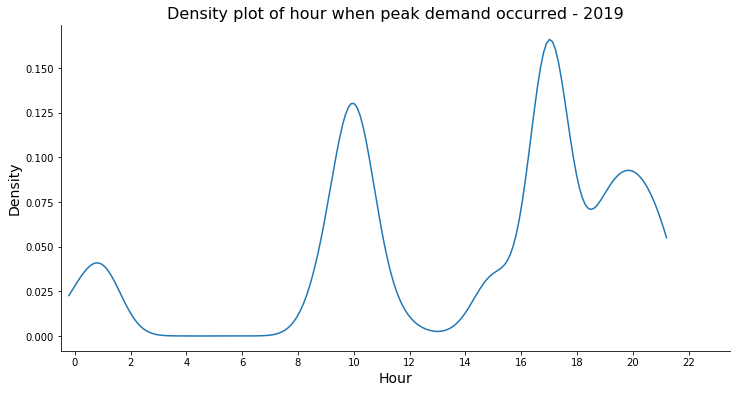

In [9]:
fig, ax = plt.subplots(figsize=(12,6))

sns.kdeplot(data=peak_demand, x="Peak Demand Hour", bw_adjust=0.4, ax=ax, cut=0.3)

ax.set_xticks(np.arange(0,25,2))
ax.set_xlim(-0.5, 23.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel("Hour", fontsize=14)
ax.set_ylabel("Density", fontsize=14)

ax.set_title("Density plot of hour when peak demand occurred - 2019", fontsize=16)

plt.show()

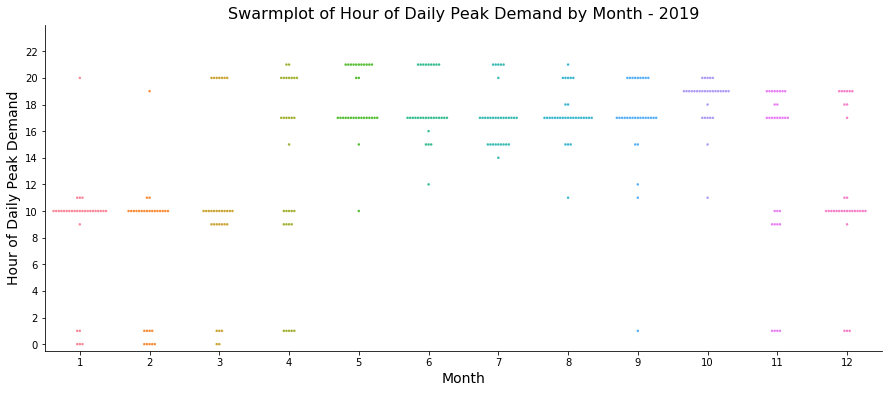

In [10]:
fig, ax = plt.subplots(figsize=(15,6))

sns.swarmplot(data=peak_demand, x="Month", y="Peak Demand Hour", size=2.5, ax=ax)

ax.set_xticks(range(0,12))
ax.set_yticks(np.arange(0,24,2))
ax.set_ylim(-0.5,24)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Hour of Daily Peak Demand", fontsize=14)

ax.set_title("Swarmplot of Hour of Daily Peak Demand by Month - 2019", fontsize=16)


plt.show()

From the above plots, it seems like most peaks do occur between 8AM-12PM and 4-6PM, with occasional peaks between 7-9PM or very early morning between 12AM-2AM. It also seems like peaks tend to occur in the early mornings and at the start of the day during the winter and early spring, and af the end of the work day and in the evenings during the summer and early fall. This seems to be a well-known and [frequently observed phenomena in other countries](https://learn.pjm.com/three-priorities/keeping-the-lights-on/how-energy-use-varies.aspx). This daily curve differentiation by season will be useful to base our hourly historical estimates.

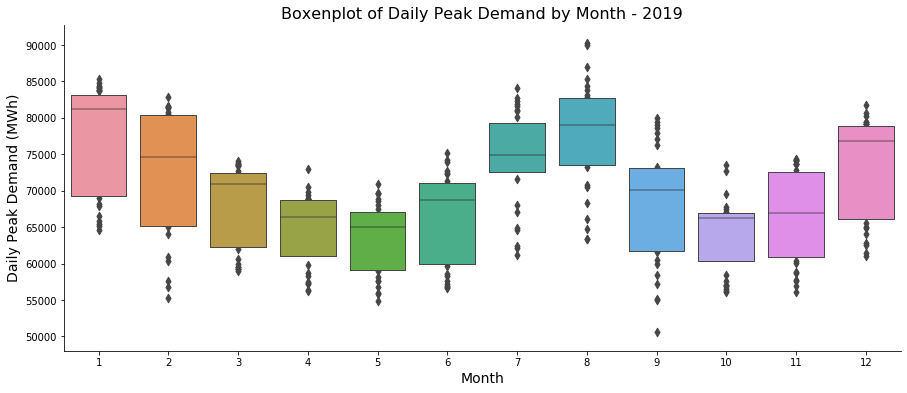

In [11]:
fig, ax = plt.subplots(figsize=(15,6))

sns.boxenplot(data=peak_demand, x="Month", y="Peak\rDemand (MW)", ax=ax)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Daily Peak Demand (MWh)", fontsize=14)

ax.set_title("Boxenplot of Daily Peak Demand by Month - 2019", fontsize=16)

plt.show()

We also see a seasonal variation in daily peak demand, with peaks in deep winter and deep summer with troughs in between seasons.

---

#### Modeling daily supply

Unfortunately, there isn't any hourly data to base a model from besides the sample EPSIS screenshot data at the top of this notebook.

![Data from Nov. 31st, 2020 (grey) and Dec 1st, 2020 (blue)](data/formatted_data/sample_daily_production_image.png)
<center><b>Data from Nov. 31st, 2020 (grey) and Dec 1st, 2020 (blue)</b></center>

<br>
Using this data sample, the `peak_demand` data, and our understanding of how the daily load curves shift throughout the year, I can start to create a basic model.

To create an hourly demand curve, I used [load data from the USA](https://dataminer2.pjm.com/feed/hrl_load_metered) (obtained through PJM) as a baseline model. I decided to do this for a few reasons:
1. The PJM regional transmission operator (RTO) in the USA and South Korea are fairly similar in terms of size, population, GDP, climate... and a few other factors which helps to use one for the other as a model
2. Simplicity - as I don't have time to build a very elaborate model, using another region as a basis and calibrating it will make it much easier to develop a solution
3. The model will be based on real hourly data rather than equations which also makes it easier to derive a daily generation curve

In [15]:
PJM = pd.read_csv("data/formatted_data/hrl_load_metered.csv")
PJM["datetime_beginning_ept"] = pd.to_datetime(PJM["datetime_beginning_ept"])
PJM.columns = ["datetime", "load"]
PJM["Year"] = PJM.datetime.dt.year
PJM["Month"] = PJM.datetime.dt.month
PJM["Day"] = PJM.datetime.dt.day
PJM["Hour"] = PJM.datetime.dt.hour

In [16]:
peak_demand_PJM = PJM.iloc[PJM.groupby(["Year","Month","Day"])["load"].idxmax().values]

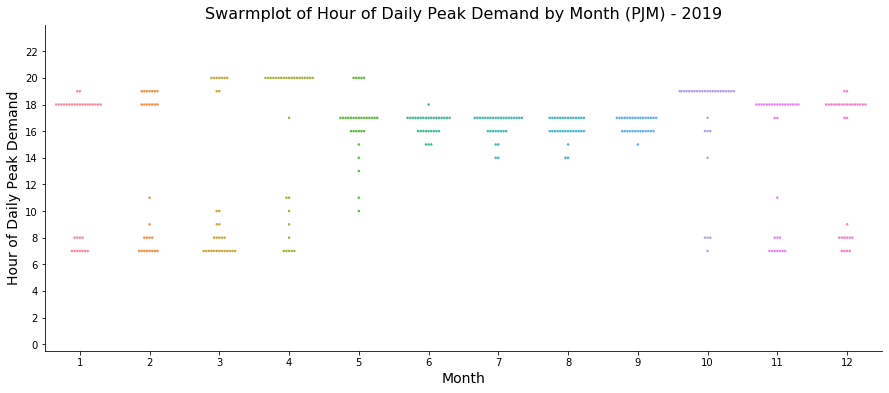

In [17]:
fig, ax = plt.subplots(figsize=(15,6))

sns.swarmplot(data=peak_demand_PJM, x="Month", y="Hour", size=2.5, ax=ax)

ax.set_xticks(range(0,12))
ax.set_yticks(np.arange(0,24,2))
ax.set_ylim(-0.5,24)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Hour of Daily Peak Demand", fontsize=14)

ax.set_title("Swarmplot of Hour of Daily Peak Demand by Month (PJM) - 2019", fontsize=16)


plt.show()

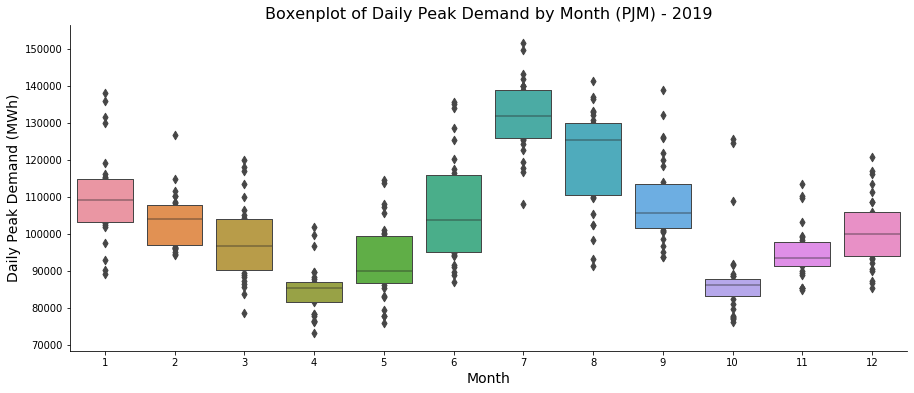

In [18]:
fig, ax = plt.subplots(figsize=(15,6))

sns.boxenplot(data=peak_demand_PJM, x="Month", y="load", ax=ax)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Daily Peak Demand (MWh)", fontsize=14)

ax.set_title("Boxenplot of Daily Peak Demand by Month (PJM) - 2019", fontsize=16)

plt.show()

Ignoring the MWh scale, the two geographies of the PJM RTO and South Korea follow roughly similar daily peak-demand profiles throughout the year. This isn't a perfect approach or fit, but I will us this as a basis to get an initial model for Korea estimates.

### Calibrating the PJM data to South Korean data

In order to match the PJM curves to South Korean data, I can adjust each daily curve relative to the peak load for each day in South Korea.

In [19]:
adj_factor = peak_demand["Peak\rDemand (MW)"].values/peak_demand_PJM["load"].values
KR_hrly = PJM.copy()

In [20]:
for i, date in enumerate(pd.date_range(start="2019-01-01", end="2019-12-31")):
    st = date
    fn = date+timedelta(days=1)
    sub_data = KR_hrly[(KR_hrly.datetime >= st) & (KR_hrly.datetime < fn)]["load"].copy()
    idx = sub_data.index
    adj_data = (sub_data*adj_factor[i]).values
    KR_hrly.loc[idx,"load"] = adj_data

In [21]:
peak_demand_fit_KR = KR_hrly.iloc[KR_hrly.groupby(["Year","Month","Day"])["load"].idxmax().values]

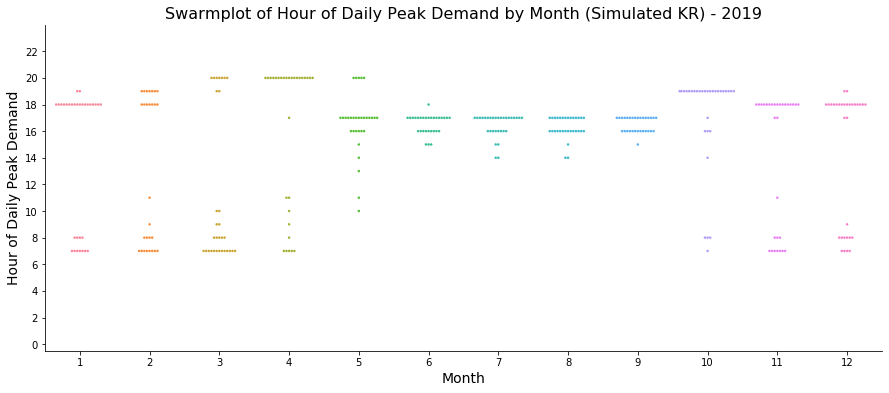

In [22]:
fig, ax = plt.subplots(figsize=(15,6))

sns.swarmplot(data=peak_demand_fit_KR, x="Month", y="Hour", size=2.5, ax=ax)

ax.set_xticks(range(0,12))
ax.set_yticks(np.arange(0,24,2))
ax.set_ylim(-0.5,24)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Hour of Daily Peak Demand", fontsize=14)

ax.set_title("Swarmplot of Hour of Daily Peak Demand by Month (Simulated KR) - 2019", fontsize=16)


plt.show()

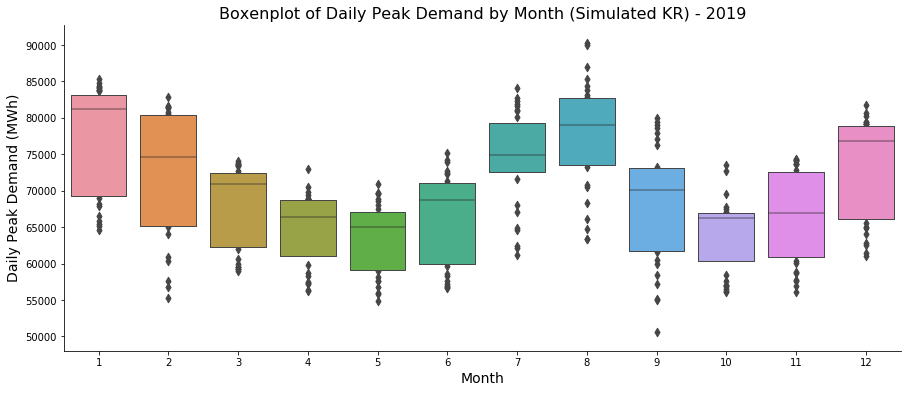

In [23]:
fig, ax = plt.subplots(figsize=(15,6))

sns.boxenplot(data=peak_demand_fit_KR, x="Month", y="load", ax=ax)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Daily Peak Demand (MWh)", fontsize=14)

ax.set_title("Boxenplot of Daily Peak Demand by Month (Simulated KR) - 2019", fontsize=16)

plt.show()

In [24]:
total_load_simulated = KR_hrly.load.sum()/1000
total_generated = generation["Total Generation (GWh)"].sum()

print("error: {:.2f}%".format((total_load_simulated-total_generated)/total_generated*100))

error: -4.95%


Our simulated synthetic hourly data is off by a factor of 4.95% relative to the total electricity generated in 2019, which isn't great but isn't too bad either!

---

### Breaking supply down into categories

Now that we have an hourly breakdown of total supply from Jan-Dec 2019, the next step is to estimate how the different fuel sources change throughout the day. Typically, we can get an insight into how a country varies the fuel source mix based on daily trends (e.g. do they buy a lot of coal ahead of time? Balance using hydro?), but we do not have this data at the hourly level for Korea. The next best approach is to assume based on what is known for other countries [how this balancing is typically done (using Germany, France and the UK as reference points](https://www.wartsila.com/energy/transition-lab/weekly-updates/23072020):

- **constant sources**: sources which are typically constant throughout the day. This includes nuclear, oil, biomass, and unknown.
- **dynamic sources**: sources that vary throughout the day to adjust to changes in load. This includes coal, gas, and hydro.
- **naturally variable sources**: sources which change naturally throughout the day due to external factors. This includes solar and wind.

Let's first break down each fuel source as a percentage of the total supply generated for each month using the `monthly_generation` data. We can then use these fractions as a reference for the amount of energy supplied daily by each fuel source on average. 

In [51]:
monthly_generation_frac = monthly_generation.copy()
monthly_generation_frac.loc[:,"biomass":] = monthly_generation.loc[:,"biomass":].divide(monthly_generation["Total(MWh)"], axis=0)
monthly_generation_frac.drop(columns=["Total(MWh)"], axis=1, inplace=True)

repeat = KR_daily.groupby(["Month"]).count()["Day"].values
monthly_generation_frac = monthly_generation_frac.loc[monthly_generation.index.repeat(repeat)]
monthly_generation_frac.reset_index(inplace=True)
monthly_generation_frac.drop(columns=["index"], inplace=True)

`KR_hrly` gives us data on daily load, so we can the values from `monthly_generation_frac` to split out the amount of energy produced by each fuel source daily.

In [52]:
KR_daily = KR_hrly.groupby(["Year","Month", "Day"]).sum().reset_index().drop(columns=["Hour"]).copy()

In [55]:
for c in monthly_generation_frac.columns[4:]:
    KR_daily[c] = KR_daily["load"]*monthly_generation_frac[c]

Now that we have daily production amounts for each fuel source, we can split them out into hourly segments.

### Modeling hourly variable sources

One important component for modeling hourly production is **naturally variable sources**. The difficult thing with these is that they depend on varying weather events rather than human control like dynamic sources. For this reason, we need some sort of climate data to base ourselves from in order to estimate energy production from these fuel sources.

In order to pull this off, I looked for relevant climate data that wasn't too obscure to use and came across the [ASHRAE International Weather Files for Energy Calculations (IWEC)](https://www.ashrae.org/technical-resources/bookstore/ashrae-international-weather-files-for-energy-calculations-2-0-iwec2). IWEC files are dervied from integrated hourly data over a prolonged period of time in order to provide the typical weather profile of a specific location over a year. This helped to provide a relatively solid baseline (although not necessarily true to the specific 2019 conditions) of weather in South Korea throughout the year. The reference files I was able to obtain were only from a period of up to 18 years prior to 1999 [[source]](http://www.equaonline.com/ice4user/new_index.html
). I only used data from Incheon, South Korea as I didn't have enough time to integrate all sources.

#### Sample climate data

In [83]:
incheon_iwec_data = pd.read_csv("data/formatted_data/Incheon_hourly_iwec_weather_data.csv")
incheon_iwec_data = incheon_iwec_data[:len(KR_hrly)] # trim to match 2019 

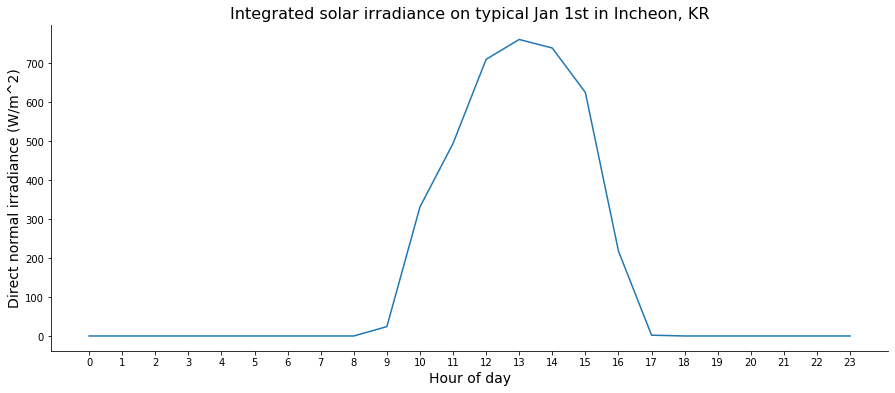

In [84]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(incheon_iwec_data[:24]["Time"], incheon_iwec_data[:24]["IDirNorm"])

ax.set_xticks(range(0,24))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel("Hour of day", fontsize=14)
ax.set_ylabel("Direct normal irradiance (W/m^2)", fontsize=14)

ax.set_title("Integrated solar irradiance on typical Jan 1st in Incheon, KR", fontsize=16)


plt.show()

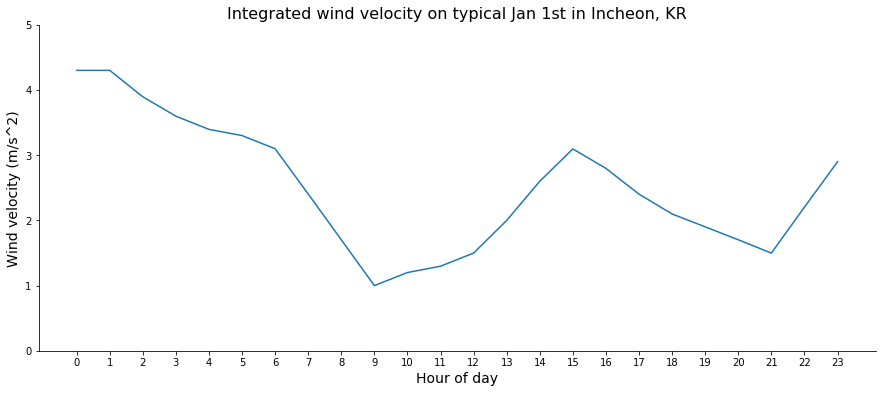

In [85]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(incheon_iwec_data[:24]["Time"], incheon_iwec_data[:24]["WindVel"])

ax.set_xticks(range(0,24))
ax.set_ylim(0,5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel("Hour of day", fontsize=14)
ax.set_ylabel("Wind velocity (m/s^2)", fontsize=14)

ax.set_title("Integrated wind velocity on typical Jan 1st in Incheon, KR", fontsize=16)


plt.show()

Now that we access to data on solar irradiance and wind velocity throughout the year, we can use this data to model the average daily power generated from solar and wind.

#### Modeling power output from solar irradiance
There are many different models that can be used to do this in more or less sophisticated ways [Example paper](https://www.mdpi.com/2071-1050/9/7/1234). For the sake of simplicity, we will simply assume that solar irradiance will be proportional to the overall power output in a data. Therefore, we can modify the scale of the solar irradiance curve such that the total area under the curve equals the amount of solar energy generated that day.

#### Modeling power output from wind
There are also many methods to accomplish this. However, we know that power generated is [proportional to the cube of wind speed](https://www.windpowerengineering.com/calculate-wind-power-output/). Using this proportionality rule, we can rescale wind velocity data such that the area under the curve also equals the total power generated by wind on a daily basis. 

### Creating hourly production factors for each variable fuel source

For this part of the model, we need to distribute daily solar and wind production throughout the day based on the weather data and related production relationships, as well as other fuel sources

In [209]:
weather_factors = incheon_iwec_data.copy()
weather_factors = pd.concat((KR_hrly[["Year","Month","Day"]], weather_factors), axis=1)
weather_factors.drop(columns=["Time"], axis=0, inplace=True)
weather_factors["hourly_solar_frac"] = 0
weather_factors["hourly_wind_frac"] = 0

In [210]:
# Create hourly solar production factor
# proportional to irradiance 

sol_factor = weather_factors.groupby(["Month", "Day"]).sum()["IDirNorm"].values

for ind, (m, d) in enumerate(weather_factors.set_index(["Month", "Day"]).index.unique().values):
    daily_fc = sol_factor[ind]
    if daily_fc > 0:
        sub_data = weather_factors[(weather_factors.Month==m)&(weather_factors.Day==d)]["IDirNorm"]
        weather_factors.loc[sub_data.index,"hourly_solar_frac"] = sub_data/daily_fc

In [211]:
# create hourly wind production factor
# proportional to cube of wind speed

wind_factor = weather_factors.copy()
wind_factor = wind_factor[["Month", "Day","WindVel"]]
wind_factor["WindVel"] = wind_factor["WindVel"]**3
wind_factor = wind_factor.groupby(["Month", "Day"]).sum().values

for ind, (m, d) in enumerate(weather_factors.set_index(["Month", "Day"]).index.unique().values):
    daily_fc = wind_factor[ind]
    if daily_fc > 0:
        sub_data = weather_factors[(weather_factors.Month==m)&(weather_factors.Day==d)]["WindVel"]**3
        weather_factors.loc[sub_data.index,"hourly_wind_frac"] = sub_data/daily_fc

In [212]:
weather_factors.drop(columns=["IDirNorm","WindVel"], inplace=True)

Now we can add each factor into the mix for all other sources using the daily simulated data

In [213]:
# create hourly production factors for constant sources
# nuclear, oil, biomass, and unknown

daily_fc = 1/24

# weather_factors["hourly_coal_frac"] = np.repeat(daily_fc,len(KR_hrly))
# weather_factors["hourly_gas_frac"] = np.repeat(daily_fc,len(KR_hrly))
# weather_factors["hourly_hydro_frac"] = np.repeat(daily_fc,len(KR_hrly))
weather_factors["hourly_nuclear_frac"] = np.repeat(daily_fc,len(KR_hrly))
weather_factors["hourly_oil_frac"] = np.repeat(daily_fc,len(KR_hrly))
weather_factors["hourly_biomass_frac"] = np.repeat(daily_fc,len(KR_hrly))
weather_factors["hourly_unknown_frac"] = np.repeat(daily_fc,len(KR_hrly))

In [214]:
weather_factors

,Year,Month,Day,hourly_solar_frac,hourly_wind_frac,hourly_nuclear_frac,hourly_oil_frac,hourly_biomass_frac,hourly_unknown_frac
0,2019,1,1,0.0,0.145360,0.041667,0.041667,0.041667,0.041667
1,2019,1,1,0.0,0.145360,0.041667,0.041667,0.041667,0.041667
2,2019,1,1,0.0,0.108031,0.041667,0.041667,0.041667,0.041667
3,2019,1,1,0.0,0.085128,0.041667,0.041667,0.041667,0.041667
4,2019,1,1,0.0,0.071545,0.041667,0.041667,0.041667,0.041667
...,...,...,...,...,...,...,...,...,...
8755,2019,12,31,0.0,0.061498,0.041667,0.041667,0.041667,0.041667
8756,2019,12,31,0.0,0.061498,0.041667,0.041667,0.041667,0.041667
8757,2019,12,31,0.0,0.061498,0.041667,0.041667,0.041667,0.041667
8758,2019,12,31,0.0,0.050065,0.041667,0.041667,0.041667,0.041667


In [215]:
# calculate marginal dist. values to see how much production is left to cover by dynamic sources

m_gen_hr = monthly_generation_frac.loc[monthly_generation_frac.index.repeat(24)].reset_index().copy()
for c in ['biomass','nuclear', 'oil', 'solar', 'wind', 'unknown']:
    abs_frac = m_gen_hr[c]*weather_factors["hourly_"+c+"_frac"]
    hr_frac_prod = (KR_hrly.load/KR_daily.loc[KR_daily.index.repeat(24)].reset_index().load)
    marginal = abs_frac/hr_frac_prod
    weather_factors[c+"_marginal_prob"] = marginal

In [219]:
# relative split between remaining dynamic sources
marg_dynamic = monthly_generation_frac[["coal", "gas", "hydro"]].copy()
marg_dynamic = marg_dynamic.divide(marg_dynamic.sum(axis=1), axis=0)
marg_dynamic = marg_dynamic.loc[marg_dynamic.index.repeat(24)].reset_index().drop(columns="index")
marg_dynamic = marg_dynamic.multiply(1-weather_factors.iloc[:,9:].sum(axis=1), axis=0)
marg_dynamic.columns = [i+"_marginal_prob" for i in marg_dynamic.columns]

In [220]:
weather_factors = pd.concat((weather_factors, marg_dynamic), axis=1)

In [247]:
# revert backward from marginal to absolute daily percentage

daily_frac_dyn = weather_factors.iloc[:,15:].multiply(hr_frac_prod, axis=0).copy()
daily_frac_dyn.columns = ["hourly_"+i.split("_")[0]+"_frac" for i in daily_frac_dyn.columns]
for c in ["coal", "gas", "hydro"]:
    daily_frac_dyn["hourly_"+c+"_frac"] = daily_frac_dyn["hourly_"+c+"_frac"]/m_gen_hr[c]

In [253]:
weather_factors = pd.concat((weather_factors, daily_frac_dyn), axis=1)

### Generate final estimates for hourly production by fuel source

In [260]:
KR_hourly_production = KR_hrly.copy()

KR_daily_grid = KR_daily.loc[KR_daily.index.repeat(24)].reset_index().copy()
KR_daily_grid.drop(columns="index", inplace=True)

In [261]:
# fill in values for constant fuel sources

for c in KR_daily.columns[4:]:
    KR_hourly_production["power_production_"+c+"_avg"] = KR_daily_grid[c].multiply(weather_factors["hourly_"+c+"_frac"], axis=0)

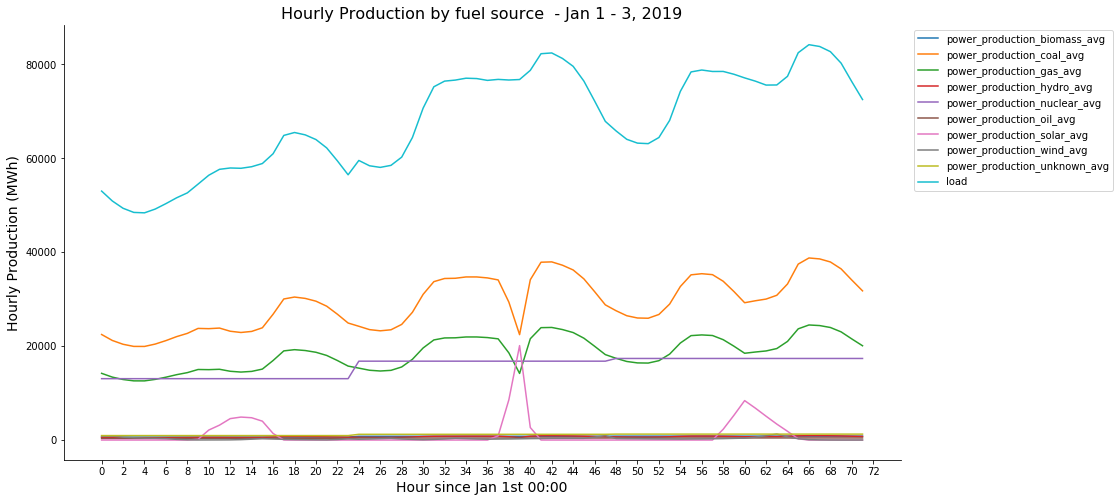

In [296]:
fig, ax = plt.subplots(figsize=(15,8))

for c in KR_hourly_production.columns[6:]:
    ax.plot(KR_hourly_production[:72][c], label=c)
    
ax.plot(KR_hourly_production[:72]["load"], label="load")

ax.set_xticks(np.arange(0,73,2))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel("Hour since Jan 1st 00:00", fontsize=14)
ax.set_ylabel("Hourly Production (MWh)", fontsize=14)

ax.set_title("Hourly Production by fuel source  - Jan 1 - 3, 2019", fontsize=16)

plt.legend(bbox_to_anchor=(1.01, 1.0))

plt.show()

In [297]:
KR_hourly_production.iloc[:,6:].sum().sum()/1000

534065.6627326694

In [294]:
monthly_generation["Total(MWh)"].sum()/1000

563040.0

In [301]:
print("final error:")
(534065-563040)/563040

final error:


-0.05146170787155442

---

### Finalise dataset format to fit required output

In [309]:
def convert_datetime_to_int(datetime_obj):
    """
    Datetime object has the following format:
    datetime(year, month, day, hour, minute, second, microsecond)
    """
    org_datetime = datetime(1970,1,1,0,0,0,0)
    timestamp = int((datetime_obj-org_datetime).total_seconds())
    return timestamp

In [ ]:
KR_hourly_production.drop(columns=["Year", "Month", "Day", "Hour"], inplace=True)
KR_hourly_production["power_production_geothermal_avg"] = 0.0
KR_hourly_production["timestamp"] = KR_hourly_production.datetime.apply(lambda x:convert_datetime_to_int(x))
KR_hourly_production["zone_name"] = "GMT+9"

KR_hourly_production.columns = ['datetime', 'total_consumption_avg', 'power_production_biomass_avg',
                                'power_production_coal_avg', 'power_production_gas_avg',
                                'power_production_hydro_avg', 'power_production_nuclear_avg',
                                'power_production_oil_avg', 'power_production_solar_avg',
                                'power_production_wind_avg', 'power_production_unknown_avg',
                                'power_production_geothermal_avg', 'timestamp', 'zone_name']

KR_hourly_production =  KR_hourly_production[['datetime', 'timestamp', 'zone_name',
                      'total_consumption_avg', 
                      'power_production_biomass_avg',
                      'power_production_coal_avg', 
                      'power_production_gas_avg',
                      'power_production_hydro_avg',
                      'power_production_nuclear_avg',
                      'power_production_oil_avg', 
                      'power_production_solar_avg',
                      'power_production_wind_avg', 'power_production_geothermal_avg',
                      'power_production_unknown_avg',
                      ]]

In [254]:
"""
datetime	ISO format (UTC)
timestamp	Integer
zone_name	string
total_consumption_avg	MW
power_production_biomass_avg	MW
power_production_coal_avg	MW
power_production_gas_avg	MW
power_production_hydro_avg	MW
power_production_nuclear_avg	MW
power_production_oil_avg	MW
power_production_solar_avg	MW
power_production_wind_avg	MW
power_production_geothermal_avg	MW
power_production_unknown_avg	MW
"""

'\ndatetime\tISO format (UTC)\ntimestamp\tInteger\nzone_name\tstring\ntotal_consumption_avg\tMW\npower_production_biomass_avg\tMW\npower_production_coal_avg\tMW\npower_production_gas_avg\tMW\npower_production_hydro_avg\tMW\npower_production_nuclear_avg\tMW\npower_production_oil_avg\tMW\npower_production_solar_avg\tMW\npower_production_wind_avg\tMW\npower_production_geothermal_avg\tMW\npower_production_unknown_avg\tMW\n'

#### Save data to csv

In [322]:
KR_hourly_production.to_csv("output/KR_hourly_production_2019.csv", index=False)

---

## Improvements

- This model was built using limited time and therefore limited data. I would have liked to coordinate with a Korean speaker (I only speak a little) in order to make sure I was accessing the best data possible
- Aggregate demand is based on various segments (industrial, residential...) which isn't taken into account in my model. In order to create an even more precise demand curve, I would have wanted to model each segment individually to get a clearer view on how demand and peak demand changes by segment
- Since I didn't have hourly consumption data, I used France to model daily load curves from based on a rudimentary analysis of climate similarity between countries. I would need to find a way to study these patterns more closely either through collecting data, or access studies which have looked at and/or modelled daily electricity consumption in South Korea
- I used consumption load data to estimate electricity generation - however, these are different sides of the grid and do not always perfectly align
- My model was very rudimentary and I would have wanted to spend more time developing a more sophisticated model - either a parametric model using well-established demand/supply estimation models, or some form of synthetic model which could use ML trained on past data.
